# 示例：剩余使用寿命预测

In [1]:
import torch
from fastphm.data import Dataset
from fastphm.data.FeatureExtractor import FeatureExtractor
from fastphm.data.loader.bearing.XJTULoader import XJTULoader
from fastphm.data.labeler.BearingRulLabeler import BearingRulLabeler
from fastphm.data.processor.RMSProcessor import RMSProcessor
from fastphm.metric.end2end.PHM2008Score import PHM2008Score
from fastphm.metric.end2end.PHM2012Score import PHM2012Score
from fastphm.metric.end2end.PercentError import PercentError
from fastphm.data.stage.BearingStageCalculator import BearingStageCalculator
from fastphm.data.stage.fpt.ThreeSigmaFPTCalculator import ThreeSigmaFPTCalculator
from fastphm.model.pytorch.base.BaseTester import BaseTester
from fastphm.model.pytorch.base.BaseTrainer import BaseTrainer
from fastphm.model.pytorch.basic.CNN import CNN
from fastphm.metric.Evaluator import Evaluator
from fastphm.metric.end2end.MAE import MAE
from fastphm.metric.end2end.MSE import MSE
from fastphm.metric.end2end.RMSE import RMSE
from fastphm.model.pytorch.callback.CheckGradientsCallback import CheckGradientsCallback
from fastphm.model.pytorch.callback.EarlyStoppingCallback import EarlyStoppingCallback
from fastphm.model.pytorch.callback.TensorBoardCallback import TensorBoardCallback
from fastphm.util.Plotter import Plotter

### 定义 数据加载器、特征提取器、fpt计算器、eol计算器

In [2]:
data_loader = XJTULoader('D:\\data\\dataset\\XJTU-SY_Bearing_Datasets')
feature_extractor = FeatureExtractor(RMSProcessor(data_loader.continuum))
fpt_calculator = ThreeSigmaFPTCalculator()
stage_calculator = BearingStageCalculator(data_loader.continuum, fpt_calculator)
Plotter.DPI = 80

[DEBUG   14:20:12]  
[DataLoader]  Root directory: D:\data\dataset\XJTU-SY_Bearing_Datasets
	✓ Bearing1_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_1
	✓ Bearing1_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_2
	✓ Bearing1_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_3
	✓ Bearing1_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_4
	✓ Bearing1_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\35Hz12kN\Bearing1_5
	✓ Bearing2_1, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_1
	✓ Bearing2_2, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_2
	✓ Bearing2_3, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_3
	✓ Bearing2_4, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_4
	✓ Bearing2_5, location: D:\data\dataset\XJTU-SY_Bearing_Datasets\37.5Hz11kN\Bearing2_5
	✓ Bearing3_1, location: D:\data\datas

### 获取原始数据、特征数据、阶段数据

In [3]:
bearing = data_loader("Bearing1_3", 'Horizontal Vibration')
feature_extractor(bearing)
stage_calculator(bearing)

[INFO    14:20:12]  [DataLoader]  -> Loading data entity: Bearing1_3
[INFO    14:20:15]  [DataLoader]  ✓ Successfully loaded: Bearing1_3


### 生成训练数据

In [4]:
generator = BearingRulLabeler(2048, is_from_fpt=False, is_rectified=True)
data_set = generator(bearing)
train_set, test_set = data_set.split_by_ratio(0.7)

### 配置训练算法

In [5]:
train_config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dtype': torch.float32,
    'epochs': 20,
    'batch_size': 256,
    'lr': 0.01,
    'weight_decay': 0.0,
}
trainer = BaseTrainer(train_config)

### 定义模型并训练

[INFO    14:20:15]  
[Trainer]  Start training by BaseTrainer:
	training set: Bearing1_3
	device: cuda
	dtype: torch.float32
	epochs: 20
	batch_size: 256
	lr: 0.01
	weight_decay: 0.0
	callbacks: []
	criterion: MSELoss()
	optimizer: Adam
[INFO    14:20:16]  [BaseTrainer]  Epoch [1/20], MSELoss:0.9514
[INFO    14:20:16]  [BaseTrainer]  Epoch [2/20], MSELoss:0.1000
[INFO    14:20:16]  [BaseTrainer]  Epoch [3/20], MSELoss:0.0201
[INFO    14:20:16]  [BaseTrainer]  Epoch [4/20], MSELoss:0.0092
[INFO    14:20:16]  [BaseTrainer]  Epoch [5/20], MSELoss:0.0040
[INFO    14:20:16]  [BaseTrainer]  Epoch [6/20], MSELoss:0.0025
[INFO    14:20:16]  [BaseTrainer]  Epoch [7/20], MSELoss:0.0021
[INFO    14:20:16]  [BaseTrainer]  Epoch [8/20], MSELoss:0.0019
[INFO    14:20:16]  [BaseTrainer]  Epoch [9/20], MSELoss:0.0016
[INFO    14:20:16]  [BaseTrainer]  Epoch [10/20], MSELoss:0.0015
[INFO    14:20:16]  [BaseTrainer]  Epoch [11/20], MSELoss:0.0014
[INFO    14:20:16]  [BaseTrainer]  Epoch [12/20], MSELoss

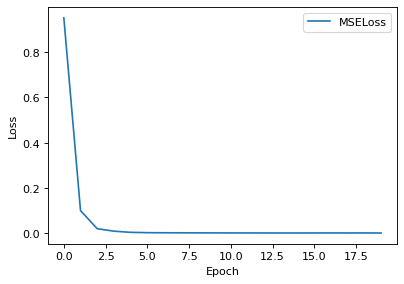

In [6]:
model = CNN(2048, 1)
losses = trainer.train(model, train_set)
Plotter.loss(losses)

### 做出预测

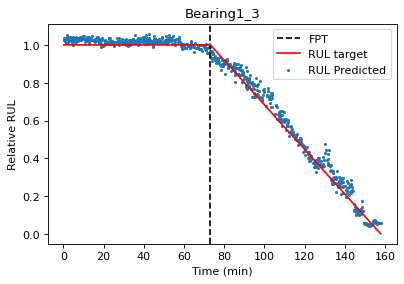

'default'

In [7]:
tester = BaseTester()
result = tester.test(model, test_set)
Plotter.rul_end2end(test_set, result, label_x='Time (min)', label_y='Relative RUL')

### 预测结果评价

In [8]:
evaluator = Evaluator()
evaluator.add(MAE(), MSE(), RMSE(), PercentError(), PHM2012Score(), PHM2008Score())
evaluator(test_set, result)

[INFO    14:20:17]  
[Evaluator]  Performance Evaluation:
               MAE     MSE    RMSE PercentError PHM2012Score PHM2008Score
Bearing1_3  0.0277  0.0012  0.0348       -2.23%       0.6378       2.0030



,MAE,MSE,RMSE,PercentError,PHM2012Score,PHM2008Score
Bearing1_3,0.0277,0.0012,0.0348,-2.23%,0.6378,2.0030
